In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils

# Template: Plot metrics, poke the model 

This file provides a template of how to look at all the metrics of a model. The functions here can be used **while the model is still training**. If it works on your computer, you can use `%matplotlib interactive` to pan the figures in the browser.

To use it, it is advised to first **copy** the notebook to something else specific to your experiment, and leave this template alone.

In [85]:
# Locate the samples and metrics' meta data in disk.

log_dir = Path("/scratches/huygens/ag919/logs/200930_linear/1")
samples = h5py.File(log_dir/"samples.pt", "r", swmr=True)
metrics = h5py.File(log_dir/"metrics.h5", "r", swmr=True)
metrics.keys()

<KeysViewHDF5 ['acc', 'acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'test', 'timestamps', 'total_energy']>

## Plot metrics

In [87]:
mask = (metrics['acceptance/is_sample'][:] == 1)
#mask = np.where(mask)[0][::10]

# This is where the samples have been taken (and accepted or rejected:)

(-2.0, 2.0)

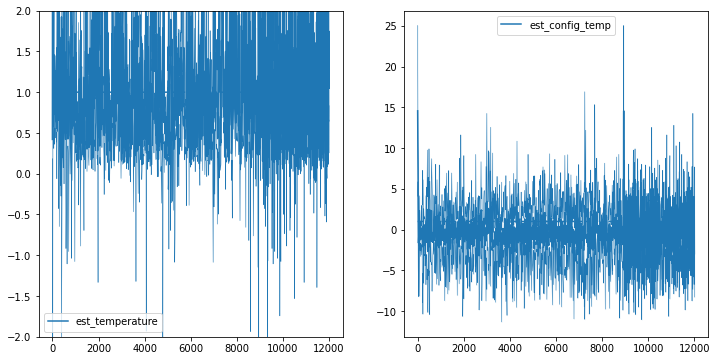

In [88]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))

plot.temperature_stderr(axes[0], metrics, "est_temperature", samples, mask=mask)
axes[0].set_ylim(-2, 2)
plot.temperature_stderr(axes[1], metrics, "est_config_temp", samples, mask=mask)
axes[0].set_ylim(-2, 2)


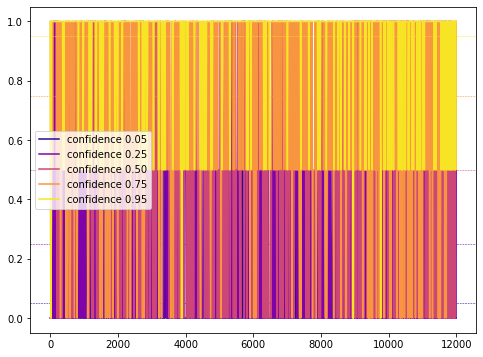

In [89]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))

plot.kinetic_temperature_intervals(ax, metrics, samples, mask=mask)

In [90]:
np.where(~np.isnan(metrics['lr'])), metrics["steps"][~np.isnan(metrics['lr'])]

((array([    0,    11,    22, ..., 10989, 10997, 11000]),),
 array([    0,    12,    24, ..., 11988, 11996, 12000]))

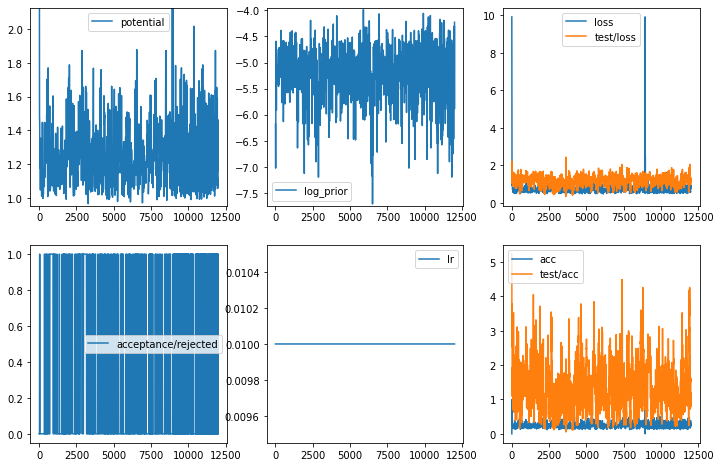

In [92]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

plot.metric(axes[0, 0], metrics, 'potential', mask=~np.isnan(metrics['potential']), iqr_ylim=4)
plot.metric(axes[0, 1], metrics, 'log_prior', mask=~np.isnan(metrics['log_prior']), iqr_ylim=4)

test_mask = ~np.isnan(metrics["test/loss"])

plot.metric(axes[0, 2], metrics, 'loss', mask=~np.isnan(metrics['loss']),)
plot.metric(axes[0, 2], metrics, 'test/loss', mask=test_mask)

#for k in metrics["preconditioner"].keys():
#    plot.metric(axes[1, 0], metrics, "preconditioner/"+k, legend=False)

#plot.metric(axes[1, 0], metrics, "delta_energy", mask=(~np.isnan(metrics['delta_energy'])) & mask)
plot.metric(axes[1, 0], metrics, "acceptance/rejected", mask=(~np.isnan(metrics['delta_energy'])) & mask)


plot.metric(axes[1, 1], metrics, 'lr', mask=~np.isnan(metrics['lr']),)

plot.metric(axes[1, 2], metrics, 'acc',  mask=~np.isnan(metrics['acc']),)
plot.metric(axes[1, 2], metrics, 'test/acc', mask=test_mask)

In [93]:
np.mean(metrics['acceptance/rejected'][mask])

0.3198090692124105

In [55]:
np.array_equal(samples["steps"][:], metrics["steps"][mask])

False

In [74]:
samples["steps"][720:750]

array([8652, 8664, 8676, 8688, 8700, 8712, 8724, 8736, 8748, 8760, 8772,
       8784, 8796, 8808, 8820, 8832, 8844, 8856, 8868, 8880, 8892, 8904,
       8916, 8928, 8940, 8952, 8964, 8976, 8988, 9000])

In [64]:
set(metrics["steps"][mask]) - set(samples["steps"])

{0,
 8936,
 8948,
 8960,
 8972,
 8984,
 8996,
 9008,
 9020,
 9032,
 9044,
 9056,
 9068,
 9080,
 9092,
 9104,
 9116,
 9128,
 9140,
 9152,
 9164,
 9176,
 9188,
 9200,
 9212,
 9224,
 9236,
 9248,
 9260,
 9272,
 9284,
 9296,
 9308,
 9320,
 9332,
 9344,
 9356,
 9368,
 9380,
 9392,
 9404,
 9416,
 9428,
 9440,
 9452,
 9464,
 9476,
 9488,
 9500,
 9512,
 9524,
 9536,
 9548,
 9560,
 9572,
 9584,
 9596,
 9608,
 9620,
 9632,
 9644,
 9656,
 9668,
 9680,
 9692,
 9704,
 9716,
 9728,
 9740,
 9752,
 9764,
 9776,
 9788,
 9800,
 9812,
 9824,
 9836,
 9848,
 9860,
 9872,
 9884,
 9896,
 9908,
 9920,
 9932,
 9944,
 9956,
 9968,
 9980,
 9992,
 10004,
 10016,
 10028,
 10040,
 10052,
 10064,
 10076,
 10088,
 10100,
 10112,
 10124,
 10136,
 10148,
 10160,
 10172,
 10184,
 10196,
 10208,
 10220,
 10232,
 10244,
 10256,
 10268,
 10280,
 10292,
 10304,
 10316,
 10328,
 10340,
 10352,
 10364,
 10376,
 10388,
 10400,
 10412,
 10424,
 10436,
 10448,
 10460,
 10472,
 10484,
 10496,
 10508,
 10520,
 10532,
 10544,
 1055

## Load and poke the model

In [40]:
with open(log_dir/"config.json", "r") as f:
    config = json.load(f)
config["model"]

'linear'

In [8]:
mcmc_burnin = 0

state_dict_samples = exp_utils.load_samples(log_dir/"samples.pt", idx=np.s_[mcmc_burnin:])
if config["reject_samples"]:
    # Making sure that rejected samples have the same value as the previous one
    print("made sure of rejected samples")
    exp_utils.reject_samples_(state_dict_samples, metrics)

del state_dict_samples["steps"]
del state_dict_samples["timestamps"]

In [9]:
device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                                "model",
                                "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                                "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                                "weight_prior_params", "bias_prior_params"))})